In [116]:
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy import stats

sns.set_style("white")

In [117]:
def sort_criterion(row):
   if row['name'] == 'baseline':
      return 1
   if row['name'] == 'detector':
      return 2
   if row['name'] == 'positioner':
      return 3
   if row['name'] == 'collector':
      return 4
   if row['name'] == 'inducer':
      return 5
   if row['name'] == 'integrated':
      return 6   
   return 7

In [118]:
df_train = pd.read_csv("./timing_train.csv")
# add a sort criterion
df_train['sort_ordinal'] = df_train.apply(sort_criterion, axis=1)
df_train.sort_values('sort_ordinal', inplace=True)
df_train.head(10)

,timestamp,task,name,seed,duration,sort_ordinal
15,2024-06-03 13:46:53.534,train,baseline,7,106.812375,1
18,2024-06-03 13:52:37.852,train,baseline,10,114.384663,1
17,2024-06-03 13:50:43.178,train,baseline,9,115.305400,1
16,2024-06-03 13:48:47.572,train,baseline,8,113.722071,1
19,2024-06-03 13:54:27.146,train,baseline,11,108.987823,1
6,2024-06-03 14:04:44.358,train,detector,8,280.605259,2
5,2024-06-03 14:00:03.418,train,detector,7,272.205814,2
7,2024-06-03 14:09:25.743,train,detector,9,281.046618,2
8,2024-06-03 14:14:09.885,train,detector,10,283.804271,2
9,2024-06-03 14:18:49.629,train,detector,11,279.281429,2


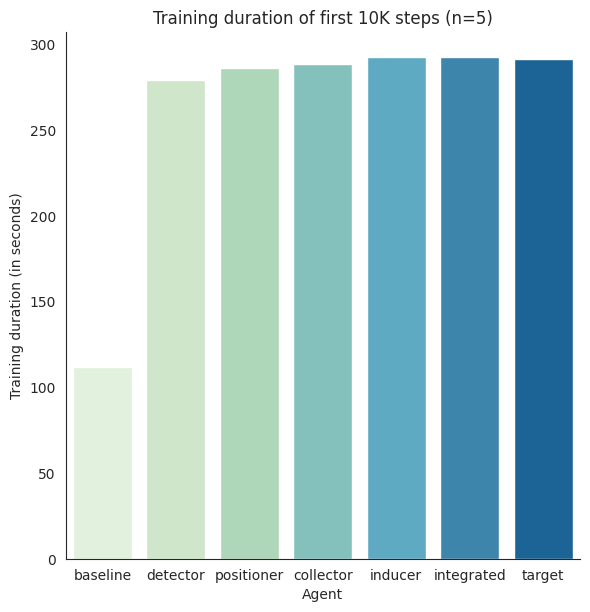

In [119]:
sns.set_style("white")
fig = sns.catplot(data=df_train, kind="bar", x="name", y="duration", errorbar=None, hue='name', palette='GnBu', height=6).set(title="Training duration of first 10K steps (n=5)", xlabel="Agent", ylabel="Training duration (in seconds)")
fig.savefig("./timing_train_duration.png")

In [120]:
df_steps = pd.read_csv("./timing_step.csv")
df_steps['sort_ordinal'] = df_steps.apply(sort_criterion, axis=1)
df_steps.sort_values('sort_ordinal', inplace=True)
df_steps.head(5)

,timestamp,task,name,seed,duration,sort_ordinal
40,2024-06-03 13:45:07.307,steps,baseline,7,0.010218,1
41,2024-06-03 13:45:07.318,steps,baseline,7,0.010507,1
42,2024-06-03 13:45:07.328,steps,baseline,7,0.010144,1
43,2024-06-03 13:45:07.338,steps,baseline,7,0.010145,1
44,2024-06-03 13:45:07.349,steps,baseline,7,0.010400,1


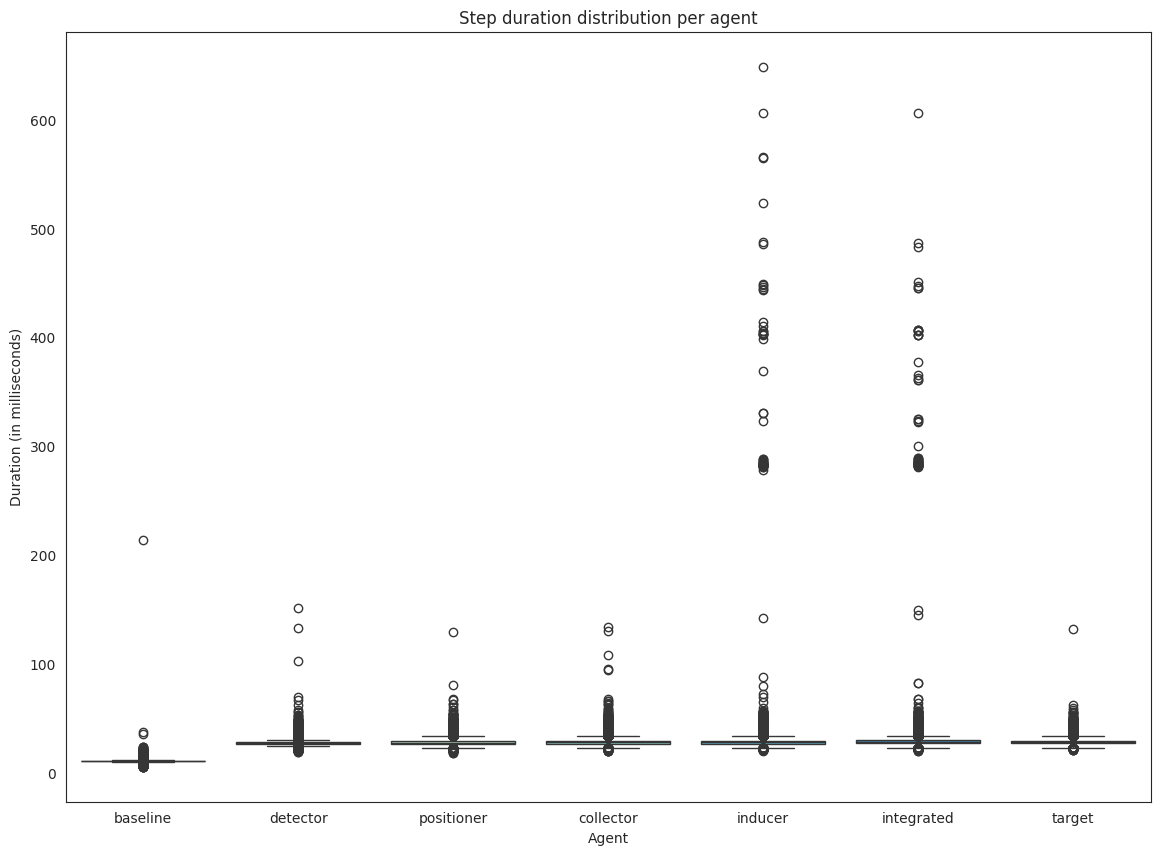

In [121]:
df_steps["duration_millis"] = df_steps["duration"] * 1000
plt.figure(figsize=(14, 10))
sns.set_style("white")
sns.set_palette(palette='GnBu', n_colors=7)
ax = sns.boxplot(x ="name", y="duration_millis", data = df_steps, hue="name", legend=False).set(title='Step duration distribution per agent', xlabel="Agent", ylabel="Duration (in milliseconds)")
plt.savefig('./timing_step_duration.png')

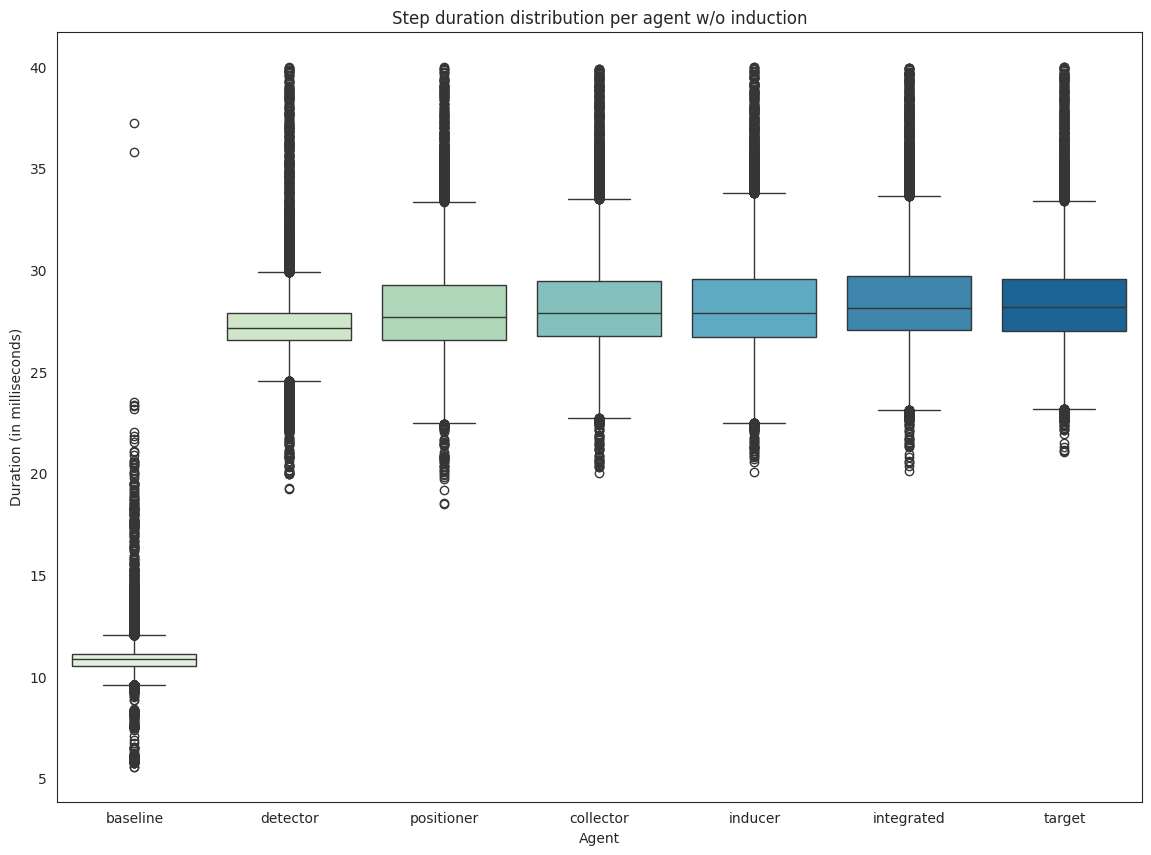

In [122]:
df_steps_no_induction = df_steps[df_steps.duration_millis < 40].copy()
df_steps_no_induction["duration_millis"] = df_steps_no_induction["duration"] * 1000
plt.figure(figsize=(14, 10))
sns.set_style("white")
sns.set_palette(palette='GnBu', n_colors=7)
fig = sns.boxplot(x ="name", y="duration_millis", data = df_steps_no_induction, hue="name", legend=False).set(title='Step duration distribution per agent w/o induction', xlabel="Agent", ylabel="Duration (in milliseconds)")
plt.savefig("./timing_step_duration_no_induction.png")

Compare the agents with a one-sided t-test, in incremental order.
Downsize sample if p-value hits 0.0 or 1.0

In [123]:
# take the last 100K steps, and then sample 1000 data points.
df_steps_baseline = df_steps[df_steps["name"] == "baseline"].sample(100, random_state=42)
df_steps_detector = df_steps[df_steps["name"] == "detector"].sample(100, random_state=3)
df_steps_baseline.describe()

,seed,duration,sort_ordinal,duration_millis
count,100.000000,100.000000,100.0,100.000000
mean,9.030000,0.010967,1.0,10.967195
std,1.431641,0.000870,0.0,0.869978
min,7.000000,0.008214,1.0,8.214100
25%,8.000000,0.010532,1.0,10.531723
50%,9.000000,0.010885,1.0,10.885325
75%,10.000000,0.011193,1.0,11.193400
max,11.000000,0.013256,1.0,13.255750


In [124]:
df_steps_detector.describe()

,seed,duration,sort_ordinal,duration_millis
count,100.000000,100.000000,100.0,100.000000
mean,8.910000,0.027435,2.0,27.434895
std,1.422013,0.001599,0.0,1.598861
min,7.000000,0.022794,2.0,22.794090
25%,8.000000,0.026780,2.0,26.780475
50%,9.000000,0.027158,2.0,27.158240
75%,10.000000,0.027881,2.0,27.881005
max,11.000000,0.037202,2.0,37.201700


200Perform a one-sided t-test using the following hypotheses:

Null: the mean step duration of the detector agent is not larger than the mean step duration of the baseline.

Alternative: the mean step duration of the detector agent is larger than the mean step duration of the baseline.

In [125]:
stats.ttest_ind(df_steps_detector["duration_millis"], df_steps_baseline["duration_millis"], alternative='greater')

TtestResult(statistic=90.47069096457287, pvalue=2.5748448745639043e-163, df=198.0)

With a p-value < 0.05, we can reject the null-hypothesis and conclude that the mean step duration of the integrated agent is larger than the mean step duration of the baseline. This seems somewhat trivial in this case, but this may not be true in the subsequent comparisons.

Null: the mean step duration of the positioner agent is not larger than the mean step duration of the detector agent.

Alternative: the mean step duration of the positioner agent is larger than the mean step duration of the detector agent.

In [126]:
df_steps_detector = df_steps[df_steps["name"] == "detector"].sample(10000, random_state=2)
df_steps_positioner = df_steps[df_steps["name"] == "positioner"].sample(10000, random_state=9)
stats.ttest_ind(df_steps_positioner["duration_millis"], df_steps_detector["duration_millis"], alternative='greater')

TtestResult(statistic=23.144492519133387, pvalue=2.839558173483235e-117, df=19998.0)

Null: the mean step duration of the collector agent is not larger than the mean step duration of the positioner agent.

Alternative: the mean step duration of the collector agent is larger than the mean step duration of the positioner agent.

In [127]:
df_steps_positioner = df_steps[df_steps["name"] == "positioner"].sample(10000, random_state=4)
df_steps_collector = df_steps[df_steps["name"] == "collector"].sample(10000, random_state=11)
stats.ttest_ind(df_steps_collector["duration_millis"], df_steps_positioner["duration_millis"], alternative='greater')

TtestResult(statistic=7.020216267913053, pvalue=1.143109706003373e-12, df=19998.0)

Null: the mean step duration of the inducer agent is not larger than the mean step duration of the collector agent.

Alternative: the mean step duration of the inducer agent is larger than the mean step duration of the collector agent.

In [128]:
df_steps_collector = df_steps[df_steps["name"] == "collector"].sample(10000, random_state=12)
df_steps_inducer = df_steps[df_steps["name"] == "inducer"].sample(10000, random_state=21)
stats.ttest_ind(df_steps_inducer["duration_millis"], df_steps_collector["duration_millis"], alternative='greater')

TtestResult(statistic=3.6361426294718955, pvalue=0.00013872293632545917, df=19998.0)

Null: the mean step duration of the integrated agent is not larger than the mean step duration of the inductive agent.

Alternative: the mean step duration of the integrated agent is larger than the mean step duration of the inductive.

In [129]:
df_steps_inducer = df_steps[df_steps["name"] == "inducer"].sample(10000, random_state=5)
df_steps_integrated = df_steps[df_steps["name"] == "integrated"].sample(10000, random_state=17)
stats.ttest_ind(df_steps_integrated["duration_millis"], df_steps_inducer["duration_millis"], alternative='greater')

TtestResult(statistic=2.99450845547909, pvalue=0.0013761187771149065, df=19998.0)

Null: the mean step duration of the target agent is not larger than the mean step duration of the positioner agent.

Alternative: the mean step duration of the target agent is larger than the mean step duration of the positioner agent.

In [130]:
df_steps_positioner = df_steps[df_steps["name"] == "positioner"].sample(10000, random_state=23)
df_steps_target = df_steps[df_steps["name"] == "target"].sample(10000, random_state=8)
stats.ttest_ind(df_steps_target["duration_millis"], df_steps_positioner["duration_millis"], alternative='greater')

TtestResult(statistic=11.7207460128612, pvalue=6.331838538243158e-32, df=19998.0)

In [131]:
df_anatomy = pd.read_csv("./timing_anatomy.csv")
df_anatomy_step = pd.read_csv("./timing_anatomy_step.csv")
df_anatomy.head(5)

,timestamp,task,name,seed,duration
0,2024-06-03 11:36:34.880,detect_objects,inducer,7,0.953270
1,2024-06-03 11:36:35.033,detect_objects,inducer,7,0.071570
2,2024-06-03 11:36:35.058,detect_objects,inducer,7,0.015819
3,2024-06-03 11:36:35.082,detect_objects,inducer,7,0.015724
4,2024-06-03 11:36:35.106,detect_objects,inducer,7,0.015080


In [132]:
# Take the integrated agent  for illustrative purposes
df_anatomy = df_anatomy[df_anatomy["name"] == "integrated"]
# track_action is trivial. It isn't anatomy in the first place. Delete.
df_anatomy.drop(df_anatomy[df_anatomy.task == "track_action"].index, inplace=True)
df_anatomy.head(5)

,timestamp,task,name,seed,duration
153241,2024-06-03 12:41:04.431,position_objects,integrated,7,0.002966
153242,2024-06-03 12:41:04.581,position_objects,integrated,7,0.002395
153243,2024-06-03 12:41:04.606,position_objects,integrated,7,0.002133
153244,2024-06-03 12:41:04.630,position_objects,integrated,7,0.002173
153245,2024-06-03 12:41:04.654,position_objects,integrated,7,0.002099


In [133]:
df_detect_objects = df_anatomy[df_anatomy["task"] == "detect_objects"]
df_position_objects = df_anatomy[df_anatomy["task"] == "position_objects"]
df_try_induction = df_anatomy[df_anatomy["task"] == "try_induction"]
df_choose_action = df_anatomy[df_anatomy["task"] == "choose_action_ddqn"]

In [134]:
df_detect_objects.describe()

,seed,duration
count,51187.000000,51187.000000
mean,9.027409,0.014999
std,1.421603,0.004298
min,7.000000,0.012109
25%,8.000000,0.014716
50%,9.000000,0.015190
75%,10.000000,0.015292
max,11.000000,0.946524


In [135]:
df_position_objects.describe()

,seed,duration
count,19550.000000,19550.000000
mean,9.029719,0.002630
std,1.417063,0.000283
min,7.000000,0.002054
25%,8.000000,0.002527
50%,9.000000,0.002602
75%,10.000000,0.002685
max,11.000000,0.009107


The core implementation portion of a P1 and C1 step is the total mean step duration minus all the symbolic mean durations.
For readability, calculate them first. The unit of measurement is in seconds, so multiply by 1000 to obtain milliseconds;
Note that the induction is only applied every 1OOO steps, meaning its proportion is 1/1000, canceling out the milliseconds conversion.

In [136]:
# Take the integrated agent and baseline agent to calculate the average step duration
df_anatomy_step_integrated = df_anatomy_step[df_anatomy_step["name"] == "integrated"]
df_anatomy_step_baseline = df_anatomy_step[df_anatomy_step["name"] == "baseline"]

In [137]:
# for the total step duration
step_duration_integrated = df_anatomy_step_integrated["duration"].mean() * 1000
step_duration_baseline = df_anatomy_step_baseline["duration"].mean() * 1000

# for the symbolic parts
object_detection_int = df_detect_objects["duration"].mean() * 1000
positioning_int = df_position_objects["duration"].mean() * 1000
induction_int = df_try_induction["duration"].mean()
choose_action_int = df_choose_action["duration"].mean() * 1000

# from these, calculate the non-symbolic duration of the step
core_integrated_int = step_duration_integrated - (object_detection_int + positioning_int + induction_int + choose_action_int)


In [138]:
print(object_detection_int)

14.998812285736614


In [139]:
print(positioning_int)

2.6298476301790283


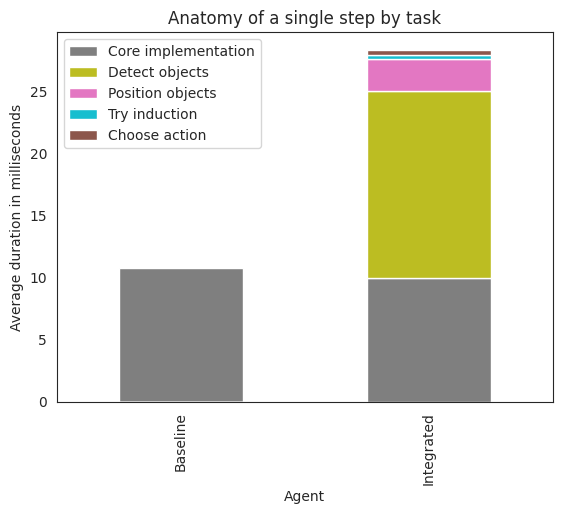

In [141]:
df = pd.DataFrame({'Core implementation': [step_duration_baseline, core_integrated_int],
                   'Detect objects': [0, object_detection_int],
                   'Position objects': [0, positioning_int],
                   'Try induction': [0, induction_int],
                   'Choose action': [0, choose_action_int]
                   },
                  index=['Baseline', 'Integrated'])

# use the Tableau matte colours for high contrast and ease on the eyes
df.plot(kind='bar', stacked=True, color=['tab:gray', 'tab:olive', 'tab:pink', 'tab:cyan', 'tab:brown'])
 
# labels for x & y axis
plt.xlabel('Agent')
plt.ylabel('Average duration in milliseconds')
 
# title of plot
plt.title('Anatomy of a single step by task')

plt.savefig("./timing_step_anatomy.png")